# Region Selector Script
- Retrieves featureDicts generated during classifySamples analyses
- Retrieves lightsheet data
- For each included region returned in the contrast, Show means across regions for each element + saline
- Sort the table of regions based on greatest relative difference b/t regions

In [1]:
def return_feature_list(f_string_template, drug, featSelMod, featSelThres, filtList, featureListUse):

    # Retrieve both the relevant dictionaries
    allRegion, allCount = [], []
    for fsMod, thres in zip(featSelMod, featSelThres):
        dataDict = dict(drug= drug, fSelMod=fsMod)
        dictPath = f_string_template.format(**dataDict)

        with open(dictPath, 'rb') as f:                 
            [name, featureDict] = pkl.load(f)

        regionList = np.array(list(featureDict.keys()))
        featureCount = np.array(list(featureDict.values()))
        
        if filtList:
            keepInd = featureCount > thres
            regionList = regionList[keepInd]
            featureCount = featureCount[keepInd]
        
        allRegion.append(regionList)
        allCount.append(featureCount)

    if featureListUse == 'both':
        # Find elements in both lists
        matching_elements = list(set(allRegion[0]).intersection(allRegion[1]))
        regionList = matching_elements

        # Extract feature counts for the new list, and turn those to alpha values
        featureIdx = [list(allRegion[1]).index(x) for x in matching_elements]
        featureCount = allCount[1][featureIdx]

    elif featureListUse == 'BorFS':
        regionList = allRegion[1]
        featureCount = allCount[1]

    elif featureListUse == 'SelectKBest':
        regionList = allRegion[0]
        featureCount = allCount[0]
    
    return regionList, featureCount, name

def process_lightSheet(lightsheet_data, regionList, drug, salineScale, acaNorm):
    # Use the class to extract data from lightsheetData
    ls_data_comp = lightsheet_data.copy()
    classifyDict = dict(label = f"class_{drug}") 

    conv_dict = hf.create_drugClass_dict(classifyDict)
    conv_dict['SAL'] = 'Saline'

    ls_data_comp[classifyDict['label']] = ls_data_comp['drug'].map(conv_dict)
    ls_data_comp = ls_data_comp.dropna(subset=[classifyDict['label']])

    # If scaling by ACA
    if acaNorm:
        ls_data_sums = ls_data_comp.groupby(['abbreviation', "dataset"])['count'].sum().reset_index()
        ls_data_sums_ACA = ls_data_sums[ls_data_sums.abbreviation.isin(['ACAv'])]
        ls_data_sums_ACA = ls_data_sums_ACA.groupby(['dataset'])['count'].sum()

        # Scaling factor of ACAv in mouse * mean ACAv count in all treated mice.
        ACA_drug = ls_data_sums_ACA[~ls_data_sums_ACA.index.str.contains('SAL')]
        ACA_drug_mean = ACA_drug.mean()

        for dSet in ACA_drug.index:
            # in each dataset, scale the entire dataset to the mean.
            ls_data_comp.loc[ls_data_comp['dataset'] == dSet, 'count'] = ls_data_comp.loc[ls_data_comp['dataset'] == dSet, 'count'] * ACA_drug_mean/ACA_drug[dSet]

    # Filter the table based on regions of interest
    ls_data_comp_z = ls_data_comp.groupby(['abbreviation', f"class_{drug}"])['count'].mean().reset_index()
    ls_data_comp_piv = ls_data_comp_z.pivot(index='abbreviation', columns=f"class_{drug}", values='count')
    ls_data_comp_regions = ls_data_comp_piv.loc[ls_data_comp_piv.index.isin(regionList), :]

    # Scale columns by by Saline
    fmtStr = '.0f'

    if salineScale:
        lsdc_piv_datas = ls_data_comp_regions.values
        class_names = list(ls_data_comp_regions.columns)
        sal_idx = [x == 'Saline' for x in class_names]
        other_idx = [not elem for elem in sal_idx]

        remaining_classes = list(compress(class_names, other_idx))
        remaining_data_salScale = (lsdc_piv_datas[:, other_idx] - lsdc_piv_datas[:, sal_idx])/lsdc_piv_datas[:, sal_idx]
        lsdc_piv_scaled = pd.DataFrame(remaining_data_salScale, index=ls_data_comp_regions.index, columns=remaining_classes)
        lsdc_plot = lsdc_piv_scaled
        fmtStr = '.0%'

    else: 
        lsdc_plot = ls_data_comp_regions

    # Sort the table
    lsdc_plot['Diff'] = lsdc_plot.iloc[:, 0] - lsdc_plot.iloc[:, 1]
    lsdc_plot = lsdc_plot.sort_values('Diff')
    hvAxBool = list(lsdc_plot['Diff'] > 0)
    hvAxIdx = hvAxBool.index(True)

    return lsdc_plot, fmtStr, hvAxIdx

C:\Users\aboha\AppData\Local\Temp\ipykernel_15960\707370739.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lsdc_plot['Diff'] = lsdc_plot.iloc[:, 0] - lsdc_plot.iloc[:, 1]


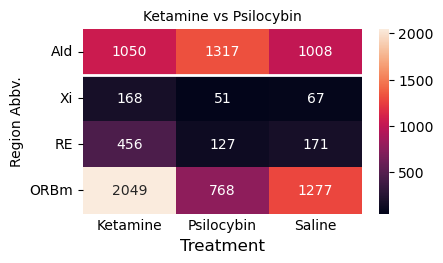

C:\Users\aboha\AppData\Local\Temp\ipykernel_15960\707370739.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lsdc_plot['Diff'] = lsdc_plot.iloc[:, 0] - lsdc_plot.iloc[:, 1]


ValueError: operands could not be broadcast together with shapes (5,) (4,) 

In [3]:
# Retrieve featureDicts
import pandas as pd
import pickle as pkl
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import compress

sys.path.append('../functionScripts/')
import helperFunctions as hf

f_string_template = "C:\OneDrive\KwanLab\Lightsheet_cFos_Pipeline\\1.scaled_Output\classif\data=count_norm-{drug}-filtMin\\PowerTrans_RobScal_fSel_{fSelMod}_clf_LogReg(multinom)_CV100\\featureDict.pkl"

# drugComps = ['Trypt', 'KetPsi', 'PsiSSRI']
# plotTitles = ["Psilocybin vs 5-MeO-DMT", "Psilocybin vs Ketamine", "Psilocybin vs A-SSRI"]
#'drug', 'class_5HT2A', 'class_Trypt', 'class_KetPsi', 'class_PsiSSRI', 'class_5HTR', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI'

# drugComps = ['KetPsi', 'Trypt', 'SSRI', 'DT']
# plotTitles = ["Psilocybin vs Ketamine", "Psilocybin vs 5-MeO-DMT", 'Acute SSRI vs Chronic SSRI', "6-F-DET vs 5-MeO-DMT"]

drugComps = ['KetPsi']
plotTitles = ["Psilocybin vs Ketamine"]

# For each drug comparison, both feature selection modalities will be checked for data.
# Each one's list is thresholded at its respective value.
featSelMod = ['SelectKBest(k=30)', 'BorFS']
featSelThres = [90, 50]
filtList = True
featureListUse = 'SelectKBest' # BorFS, SelectKBest, or 'both'

# Load lightsheetData
lightsheet_data = pd.read_pickle('lightsheet_data.pkl')

salineScale = False
acaNorm = False
regionSet = ['dict', 'control']

for drug, pltTitle in zip(drugComps, plotTitles):

    # Based on specified switches, return a feature set.
    regionList, featureCount, name = return_feature_list(f_string_template, drug, featSelMod, featSelThres, filtList, featureListUse)
    
    for regionL in regionSet:

        if regionL != 'dict':
            regionList = ['ACAd', 'ACAv', 'ILA', 'PL', 'MOs']
        if regionL == 'dict':
            regionList = ['AId', 'ORBm', 'Xi', 'RE']

        # Use the class to extract data from lightsheetData
        lsdc_plot, fmtStr, hvAxIdx = process_lightSheet(lightsheet_data, regionList, drug, salineScale, acaNorm)

        # Pulling out full names for each region
        # lightsheet_data_single = lightsheet_data[lightsheet_data['dataset'] == '6FDET1']
        # lightsheet_data_single_list = lightsheet_data_single[lightsheet_data_single['abbreviation'].isin(regionList)]
        # ref_table = lightsheet_data_single_list[['abbreviation', 'Region_Name']].drop_duplicates().reset_index(drop=True)
        
        # Save this for importing into brainrender (which has to run older versions of python/packages)
        if regionL == 'dict':
            lsdc_plot.to_csv(f'br_{pltTitle}.csv')

        # Keep only first two columns
        if salineScale:
            lsdc_plot = lsdc_plot.iloc[:, 0:2]
        else:
            lsdc_plot = lsdc_plot.iloc[:, 0:3]

        # scale factor w/ 4     - AId,   Xi,   RE,  ORBm
        regionLengths = np.array([4000, 1600, 1600, 2000])
        slice_thickness = 150
        sliceFrac = slice_thickness/regionLengths
        for region_idx in lsdc_plot.columns:
            lsdc_plot[region_idx] = lsdc_plot[region_idx] * sliceFrac

        # Plotting
        plt.figure(figsize=(1.5 * len(lsdc_plot.columns), .6 * len(lsdc_plot.index)))
        
        sns.heatmap(lsdc_plot, annot=True, fmt=fmtStr)  #, cmap='RdBu', center=0, vmin=-1, vmax=1, annot=True, fmt=fmtStr
        titleStr = f"{name[0]}"

        if regionL != 'dict':
            titleStr += ', Control Regions'

        if acaNorm:
            titleStr += ' ACA norm'

        if salineScale:
            titleStr += ' (% Change vs Saline)'

        # Draw a line for the 0 cross point
        plt.axhline(y=hvAxIdx, color='white', linewidth=2)

        plt.ylabel("Region Abbv.")
        plt.xlabel("Treatment", fontsize=12)
        plt.tick_params(axis='x', which='both', length=0)
        plt.title(titleStr, fontsize=10)
        plt.yticks(rotation=0)

        # plt.savefig(dirDict['classifyDir'] + titleStr + '.png', dpi=300, format='png', bbox_inches='tight')
        plt.show()